In [38]:
import os
import urllib.request
from timeit import timeit
import sklearn
from sklearn.datasets import load_iris, make_blobs, fetch_openml, load_digits, make_moons, fetch_olivetti_faces
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.colors import LogNorm
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.patches import Polygon

#To make the notebook's output stabel across runs
np.random.seed(42)

#Uses Jupyter's own backend to plot
%matplotlib inline

#To make pretty figures
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#Path to saving images
IMAGE_PATH = os.path.join("images")
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, fig_extension="png", tight_layout=True, resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure,", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Most applications of Machine Learning today are based on supervised learning, yet the vast majority of the available data is unlabeled: **we have input feature X, but we don't have the labels y.** Therefore, there is a huge potential in unsupervised learning.

Labeling data requires human experts to go through all the data, which is long costly and tedious task, even for a small subset from of a large dataset. Thus the labeled dataset will quite small, resulting in a poor performance from a classifier. Additionally, every time a company makes any changes to its products, the whole process will need to be started from scratch. 

**Unsupervised learning aims to exploit the unlabeled data without needing humans to label every instance in the dataset/subset.**

Dimensionality reduction is one of the common tasks for unsupervised learning and was discussed in a previous notebook. Thus, we'll focus on a few more unsupervised learning tasks and algorithms:
- **Clustering**
    - The goal is to group similar instacnes together into _clusters_. Clustering is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction and more.

- **Anomaly detection**
    - The objective is to learn what "normal" data looks like, and then use that to detect abnormal instances, such as defective items on a production line or a new trend in a time series.

- **Density estimation**
    - This is the task of estimating the _probabilty density function_ (PDF) of the random process that generated the dataset. Density estimation is commonly used for anomaly detection: instances that are located in very low-dimensional regions are more likely to be anomalies. It's also useful for data analysis and visualization.

We'll look at **clustering** first, using K-Means and DBSCAN. Then, discuss Gaussian mixture models and see how they can be used for density estimation, clustering and anomaly detection

# Section: Clustering

***Clustering*** is a task that identifies similar instances and assigning them to _clusters_ or groups of similar instances. It's just like classification, but clustering is an **unsupervised task.** 

In the following figure (figure 9-1), **on the left** is the iris dataset, where each instance's species is represented with a different marker. It's a labeled dataset, so classfication algorithms such as Logistic Regression, SVMs or Random Forest classfiers are well suited.

**On the righ** is the same dataset, but without labels, thus classifications algorithms are of no use. This is where clustering algorithms comes in, many of them can easily detect the lower-left cluster. 

The dataset has two additional features (sepal length and width), not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well - when we use Gaussian mixture model, only 5/150 are assigned to the wrong cluster (96.66% success rate).

In [19]:
iris = load_iris()
X = iris.data
y = iris.target
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure, Unsupervised Learning Techniques - Classification vs clustering


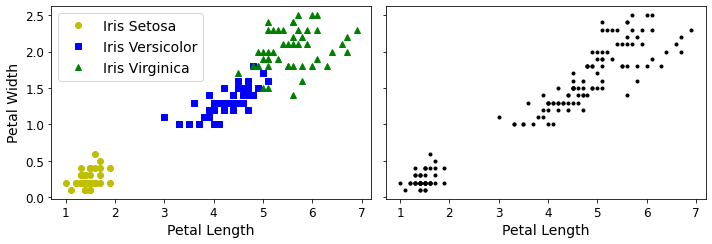

Figure 9-1


In [20]:
plt.figure(figsize=(10, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris Setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris Versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris Virginica")
plt.xlabel("Petal Length", fontsize=14)
plt.ylabel("Petal Width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal Length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("Unsupervised Learning Techniques - Classification vs clustering")
plt.show()
print("Figure 9-1")

    - A Gaussian mixture model can help separate these clusters pretty well using all 4 features: petal length and width, and sepal length and width

In [21]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

    - Let's map each cluster to a class. We'll pick the most common class for each cluster (using the scipy.stats.mode() function)

In [22]:
mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id]) #"_" ignores a value when unpacking
    mapping[mode[0]] = class_id
mapping

{1: 0, 2: 1, 0: 2}

In [23]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

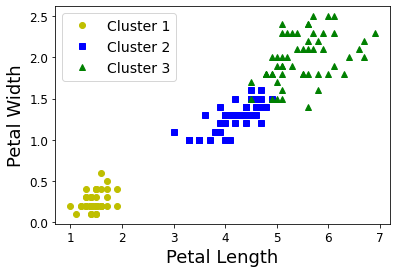

In [24]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal Length", fontsize=18)
plt.ylabel("Petal Width", fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.show()

    - Check how many right prediction we got

In [25]:
np.sum(y_pred == y)

145

In [26]:
np.sum(y_pred == y) / len(y)

0.9666666666666667

**Applications that use clustering inculde:**

- **Customer segmentation**
    - Clustering customers based on their purchases and their activity on a website. This is useful to understand who your customers are and what they need, so you can adapt your products and marketing campaigns to each segment. For instance, it can be useful in _recommender systems_ to suggest content that other users in the same cluster enjoyed.
    
    
- **Data analysis**
    - When analyzing a new dataset, it can be helpful to run a clustering algorithm, and then analyze each cluster separately
    
    
- **As a dimensionality reduction technique**
    - Once a dataset has been clustered, it's usually possible to measure each instance's _affinity_ with each cluster (_affinity_ is any measure of how will an instance fits into a cluster). Each instances' feature vector $x$ can be replaced with the vector of its clusters affinities. If there a re $k$ clusters, then this vector is $k$ dimnesional. This vector is typically much lower-dimensional than the original feature vector, but it can preserve enough information for further processing
    
    
- **Anomaly detection (also called outlier detection)**
    - Any instance that has a low affinity to all the clusters is likely to be an anomaly. For example, if you have clustered the users of your website based on their behavior, you can detect users with unusual behavior, such as an unusual request per second. Anomaly detection is paritcularly useful in detecting defects in manufacturing or fraud detection
    
    
- **Semi-supervised learning**
    - If there are only a few labels available, it's possible to perform clustering and propogate the labels to all the instances in the same cluster. This technique can greatly increase the number of labels available for subsequent supervised learning algorithm, thus improving performance
    
    
- **Search engines**
    - Some search engines allow you to search for images that are similar to a reference image. To build such a system, first apply a clustering algorithm to all the images in the database - similar images would end up in the same cluster. Then when a user provides a reference image, use the trained clustering model to find this image's cluster, and then you can return all the images from this cluster
    
    
- **To segment an image**
    - By clustering pixels according to their color, then replacing each pixel's color with the mean color of the cluster, it's possible to considerably reduce the number of different colors in the image. Image segmentation is used in many object detection and tracking systems, as it makes it easier to detect the contour of each object
    

A cluster depends on the context, and different algorithms will capture different kinds of clusters. For examples, algorithms that look for instances centered around a particular point, called _centroid_. Others look for continuous regions of densely packed instances: these clusters can take on any shape

## K-Means

In the following figure 9-2, its clear that there are 5 blobs of instances. The k-Means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often with just a few iterations. K-Means is sometimes referred to as Lloyd-Forgy, because it was published by two different people from different places

In [27]:
blob_centers = np.array([
    [ 0.2,  2.3],
    [-1.5 ,  2.3],
    [-2.8,  1.8],
    [-2.8,  2.8],
    [-2.8,  1.3]
])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [28]:
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                 random_state=7)

Saving figure, Clustering - KMeans, Unlabeled dataset of 5 blobs


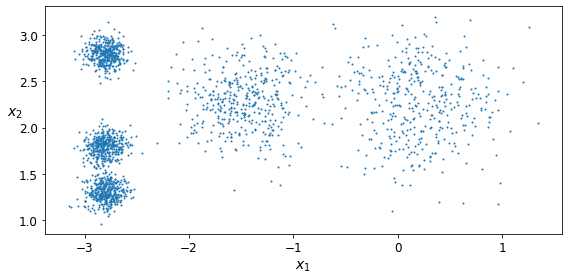

Figure 9-2


In [29]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", rotation=0, fontsize=14)

plt.figure(figsize=(8,4))
plot_clusters(X)
save_fig("Clustering - KMeans, Unlabeled dataset of 5 blobs")
plt.show()
print("Figure 9-2")

    - Fit and predict by using the KMeans on this dataset. It will try to find each blob's center and assign each instance to the closest blob

**Note** specifying the number of clusters is generally not that easy.

In [30]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

    - Each instances has been assigned to one of the 5 clusters

In [31]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

**Note** in Kmeans, the ***label*** of an instance is the **_index_ of the cluster it gets assigned to**

In [32]:
y_pred is kmeans.labels_

True

    - Estimation of the 5 centroids

In [33]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

    - Predict labels of new instances

In [17]:
X_new = np.array([
    [0, 2],
    [3, 2],
    [-3, 3],
    [-3, 2.5]
])
kmeans.predict(X_new)

array([1, 1, 2, 2])

    - Let's plot the cluster's decision boundries (gives a Voronoi diagram)

In [35]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1], marker="o", s=35, linewidths=8, 
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=2, linewidths=12,
               color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                            show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1,
            color="k")
    
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
        
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0, fontsize=14)
    else:
        plt.tick_params(labelleft=False)

<ipython-input-18-50808b416ee9>:22: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1,


Saving figure, Clustering - KMeans, decision boundaries


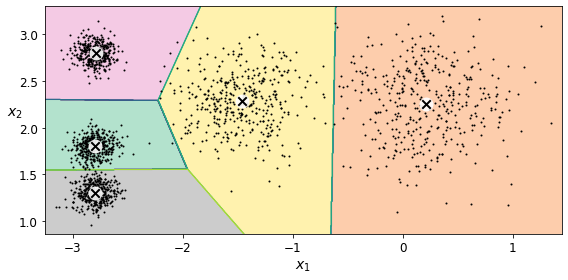

Figure 9-3


In [19]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("Clustering - KMeans, decision boundaries")
plt.show()
print("Figure 9-3")

The vast majority of the instances were clearly assigned to the appropriate cluster, but a few instance were probably mislabeled (especially near the boundary between the top-left cluster and the central cluster). 

When the blobs vary in diameters, K-Means doesn't perform that well because all it care about when assigning instances to a cluster is the distance to the centroid.

Instead of assigning each instance to a single cluster, called ***hard clustering***, it cab be useful to give each instance a score per cluster, called ***soft clustering***.

The score can be the distance between the instance and the centroid, or the similarity score (or affinity), such as the Gaussian Radial Bases Function (RBF). 

In KMeans, the ***transform()*** method measures the distance from each instance to every centroid

In [20]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

We can verify this by calculating the Euclidian distance between each instance and each centroid

In [21]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k ,2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

Recall that X_new has 4 instances and 5 clusters. We can see that the first instances distance from the first cluster is 2.81, on the second cluster it's 0.32 and so on.

If you have a high-dimensional dataset and you transform it this way, you end up with $k$-dimensional dataset: this transformation can be a very **efficient nonlinear dimnesionality reduction technique.**

### The K-Means algorithm

How does the algorithm work?
- First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
- Repeat until convergance (that is, until the centroids stop moving):
    - Assign each instance to the closest centroid
    - Update the centroids to be the mean of the instances that are assigned to them

> The computational complexity of the algorithm is generally linear with regard to the number of instances $m$, the number of clusters $k$, and the number of dimensions $n$. **However**, this is only true when the data has a clustering structure. If it doesn't, then in the worst-case scenario the complexity can increase exponentially with the number of instances. In practice this rarely happens, and K-Means is generally one of the fastest clustering algorithms

The Kmeans class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), set ***init="random"***, ***n_init=1*** and ***algorithm="full"***

In the following figure 9-4, the centroids are initialized randomly (top left), then the instances are labeled (top right), and so on. After 3 iterations, the algorithm has reached a clustering that seems fairly resonable

In [22]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full",
                     max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full",
                     max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full",
                     max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

NameError: name 'plot_data' is not defined

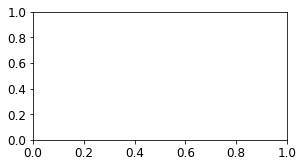

In [34]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0, fontsize=14)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("Clustering - KMeans, the algorithm")
plt.show()
print("Figure 9-4")

###### K-Means variability

In the original K-Means algorithm, the centroids are initialized randomly, and the algorithm runs a single iteration to gradually improve the centroids.

However, one major problem with this approach is that if you rub K-Means multiple times (or with different random seed), it can converge to very different solutions:

In [24]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)
    
    plt.figure(figsize=(10, 3.2))
    
    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)
        
    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X)
    if title2:
        plt.title(title2, fontsize=14)

<ipython-input-18-50808b416ee9>:22: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1,
<ipython-input-18-50808b416ee9>:22: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1,


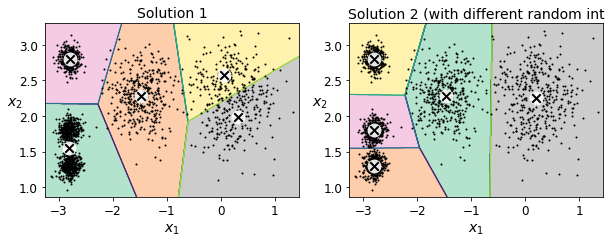

In [25]:
kmneans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                           algorithm="full", random_state=2)
kmneans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                           algorithm="full", random_state=5)
plot_clusterer_comparison(kmneans_rnd_init1, kmneans_rnd_init2, X, 
                          title1="Solution 1", 
                          title2="Solution 2 (with different random int")

##### Inertia

To select the best model, we'll need a way to evaluate a K-Means model's performance. Unfortunately, clustering is an unsupervised task, so we don't have the targets. But at least we can measure the distance between each instance and their corresponding centroid. This is the idea behind ***inertia*** metric:

In [26]:
kmeans.inertia_

211.59853725816828

**Inertia is the sum of the squared distance between an instance and its closests centroid**. We can verify it in the following way:

In [27]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816862

The **score()** method **returns the negative inertia**. Why negative? it's because a predictor's **score()** method must always repect the ""greater is better" rule

In [28]:
kmeans.score(X)

-211.59853725816836

##### Multiple initializations

**One approach to solve the variability issue is to run the k-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia.** For example, let's look at the inertia of the last two "bad" models in the previous model:

In [29]:
kmneans_rnd_init1.inertia_

219.43539442771402

In [30]:
kmneans_rnd_init2.inertia_

211.59853725816828

_kmneans_rnd_init1_ and _kmneans_rnd_init2_ have higher inertia than the first "good" model _kmeans_, which means that they're probably worse

Setting **n_init** hyperparameter will make Scikit Learn run the original algorithm **n_init** times, and selects the solution that reduces the inertia. By default, **n_init=10**

In [31]:
kmeans_rnd_10_init = KMeans(n_clusters=5, init= "random", n_init=10,
                           algorithm="full", random_state=2)
kmeans_rnd_10_init.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

In the following plot, we'll see that we ended up with the initial model, which is the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$)

<ipython-input-18-50808b416ee9>:22: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1,


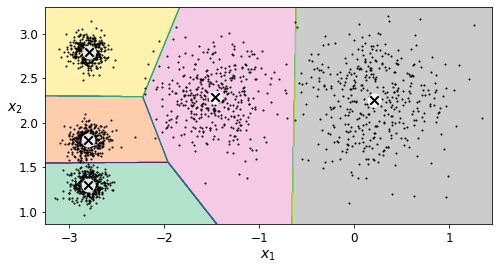

In [32]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_init, X)

Let's have a look at a few ways in which it's possible to mitigate this risk by improving the centroid initialization

##### Centroid initialization methods, K-Means++

Instead of initializing the centroids randomly, it's preferable to initialize thme using the following algorithm (proposed by David Arthur and Segei Vassilvitskii)
- Take one centroid $c_l$ chosen uniformely at random from the dataset.
- Take a new cetner $c_i$, choosing and instance $x_1$ with probability: $D(x_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}^{(j)})}^2$, where $D(x_i)$ is the distance between the instance $x_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are father away from already chosen centorids are much more likely to be selected as centroids.
- Repeat the previous steps until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialzation, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it's possible to reduce **n_init** considerably. Most of the time, this largely compenstates for the additional complexity of the initialization process

To set the initialization to K-Means++, set **init=k-means++** (default)

In [33]:
KMeans()

KMeans()

In [34]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.59853725816828

##### Accelerated K-Means and mini-batch K-Means

**Accelerated K-Means**
- The K-Means algorithm can be significantly accelerated by avoiding unnecessary distance calculations: This is achieved by exploiting the triangle inequality (i.e, that a straight line is always the shortest distance between two points) and by keeping track of lower and upper bounds for distances between instances and centorids.

To use Elkan's variant of K-Means, set **algorithm="elkan"**. Note, it doesn't support sparse data, so by default, Scikit Learn uses "elkan" for dense data and "full"(the regular K-Means algorithm) for sparse data.

In [35]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

60.8 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [36]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)

372 ms ± 790 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


**Mini-batch K-Means**
- The algorithm is capable of using mini-bathces, moving the centroids just slightly at each iteration. This speeds up the algorithm typically by a factor of 3 or 4 and makes it possible to cluster huge datasets that don't fit in memory.

In [37]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

C:\Users\Jason\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(n_clusters=5, random_state=42)

In [38]:
minibatch_kmeans.inertia_

211.93186531476786

If the data doesn't fit in memory, the simplest option is to use the **memmap** class (like in Incremental PCA)

In [39]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"],
                                                   random_state=42)

Next, we write it to a **memmap**

In [ ]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype="float32", mode="write", shape=X_train.shape)
X_mm[:] = X_train

In [ ]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

If the data is too large thus can't use **memmap**, things get more complicated. Let's start by loading the next bath (in real life, the data would be loaded from disk)

In [ ]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now train the model by feeding it one batch at a time. Also, implement multiple initializations and keep the model with the lowest inertia

In [ ]:
np.random.seed(42)

In [ ]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500 #More data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)
    
    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_
        
    if (best_kmeans is None or
       minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [ ]:
best_kmeans.score(X)

Mini-batch K-Means is much faster than regular K-Means

In [ ]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

In [ ]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

It's suppose to be faster, in our case it wasn't. It's performance is often lower (higher inertia), and it keeps degrading as $k$ increases.

Let's plot the inertia ratio and the training ratio between Mini-batch KMeans and regular KMeans

In [ ]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=14)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0 ,100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=14)
plt.title("Training time (sec)", fontsize=14)
plt.axis([1, 100, 0 ,6])

save_fig("Clustering - KMeans and mini-batch inertias and time ")
plt.show()
print("Figure 9-6")

From figure 9-6, we can see on the left that as the **number of clusters(k) increases, Mini-batch K-Means inertia increases as well (worse inertia) - compared to regular K-Mneas.** Yet on the righ, **Mini-batch K-Means is much faster than K-Means.**

##### Finding the optimal number of clusters

**Approach #1**: Up until now we set the number of clusters $k$ to 5, because from a glance we knew that it was the correct number. Yet, we won't always have an easy time knowing the number of clusters, and setting the wrong value might give a bad model

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("Clustering - KMeans, bad choices for number of clusters")
plt.show()
print("Figure 9-7")

The models above don't look too great. We can check the inertias of both models and choose the lowest one

In [ ]:
kmeans_k3.inertia_

In [ ]:
kmeans_k8.inertia_

The inertia for $k=3$ is 653.21, which is higher than for $k=5$. But with $k=8$ it's just 119.11. The **inertia isn't a good performance mertic when trying to choose $k$ because it keeps getting lower as we increase $k$.**

Indeed, the more clusters there are, the closer each instance will be to its closest centroid, therefore, the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
               for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [ ]:
inertias[3]

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.annotate("Elbow", xy=(4, inertias[3]), xytext=(0.55, 0.55),
             textcoords="figure fraction", fontsize=16, 
             arrowprops=dict(facecolor="black", shrink=0.1))
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 8.5, 0, 1300])
save_fig("Clustering - KMeans, inertia vs number of clusters")
plt.show()
print("Figure 9-8")

There is an elbow at $k=4$ - less clusters is bad while more clusters wouldn't help and we might just be splitting good clusters in half for no good reason.

Using this example, having $k=4$ isn't perfect because it means that the two blobs on the lower left will be considered as a single cluster. Nonetheless, it's still a good clustering

In [ ]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

**Approach #2**: Figuring out the number of clusters with the aforementioned technique is somewhat crude. A more precise approach (but more computationally expensive) is to use the ***silhouette score***, which is the mean ***silhouette coefficient*** over all the instances.

An instances silhouette coefficient is equal to $(b-a) / max(a, b)$, where:
- $a$ is the mean distance to the other instances in the same cluster (the _intra-cluster distance_)
- $b$ is the _mean nearest-cluster distance_ that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster)

The silhouette coefficient can vary between -1 to +1:
- A coefficient close to +1 means that the instance is well inside its own cluster and far from other cluster
- A coefficient close to 0 means that it's close to a cluster boundary
- A coefficient close to -1 means that the instance may have been assigned to the wrong cluster

Let's plot the silhouette score as a function of $k$:

In [ ]:
silhouette_score(X, kmeans.labels_)

In [ ]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

In [ ]:
plt.figure(figsize=(8,3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette scores", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("Clustering - KMeans, silhouette scores vs number of clusters")
plt.show()
print("Figure 9-9")

The figure is much richer than the previous one; in particular, although it confirms that $k=4$ is a good choce, it also shows that $k=5$ is quite good as well

To get an even more informative visualization, we can use the **silhoutette diagram** to plot every instance's silhouette coefficient sorted by the cluster they're assigned to and by the value of the coefficient

In [ ]:
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k-2)
    
    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    
    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette coefficients")
    else:
        plt.tick_params(labelbottom=False)
    
    plt.axvline(x=silhouette_scores[k-2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
    
save_fig("Clustering - KMeans, silhouette diagramss analysis")
plt.show()
print("Figure 9-10")

In the figure above, each diagram contains one knife shape per cluster. The **height** indicates the **number of instances** the cluster has, and its **width** represents the **sorted silhouette coefficients of the instances in the cluster (wider is better).** The **dashed line indicates the mean silhouette coefficient (mean silhouettescore).**

We can see that $k=5$ is the best option, because all of the clusters are roughly the same size and they all cross the dashed line

## Limits of the K-Means

K-Means limits include the following:
- Run the algorithm several times to avoid suboptimal solutions
- Specify the number of clusters
- Isn't optimized to handle clusters of varying size, different densities or nonspherical shapes

Let's see how K-Means deals with a dataset containing 3 ellipsoidal clusters of different dimensions, densities and orientations

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [ ]:
plot_clusters(X)

In [ ]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]),
                    n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)                    
kmeans_bad.fit(X)

In [ ]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("Clustering - KMeans, limits of KMeans")
plt.show()
print("Figure 9-11")

Evidently, we can't use any of the solutions. **The model on left plot**, is better but still chops off 25% of the middle cluster and assigns it to the cluster in the right, **The model on the right plot** is even worse, even though its inertia is lower.

On these types of elliptical clusters, **Gaussian mixture models work better**.

> It's important to scale the input features before runnung K-Means, or the clusters may be very stretched and K-Means will perform poorly. Scaling doesn't gurantee that all clusters will be spherical, but it generally improves things

## Using clustering for image segmentation

**Image segmentation** is the task of partitioning an image into multiple segments. In **semantic segmentation**, all pixels that are part of the same object type get assigned to the same segment. 

For instance, in self driving car's vision system, pixels that represent a pedestrian's image might go to the "pedestrian" segment.

In **instance segmentation**, all pixels that are part of the same individual object are assgined to the same segment. In this case, there would be a different segment for each pedestrian.

In this section, we'll be using **color segmentation**. We will simply assign pixels to the same segment if they have a similar color. In some applications, this may be sufficient. For example, analyzing satellite images to measure how much total forest area there is in a region.

In [ ]:
filename = "Ladybug.png"
image = imread(os.path.join(IMAGE_PATH, filename))
image.shape

The image is represented as a 3D array: Where 533=**height**, 800=**width** and 3=**number of color channels (RGB)**.

The following code reshapes the array to get a long list of RGB colors, then it clusters these colors using K-Means. Next, for each color, it looks for the mean color of the pixel's color cluster. For examples, all shades of green may be replaced with the same light green color. Finally, it reshapes this long list of colors to get the same shape as the original image

In [ ]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [ ]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

In [ ]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis("off")

save_fig("Clustering - KMeans, Image segmentation using color clusters")
plt.show()
print("Figure 9-12")

From the figure 9-12 we see that if fewer than 8 clusters is used, the ladybugs red color fails to get a cluster of its own - it merges with the environment. 

This is because K-Means prefers clusters of similar sizes. The ladybug is small, thus even though it has a distinct color, K-Means fail to dedicate a cluster to it

## Using clustering for preprocessing

Clustering is an efficient approach to dimensionality reduction, specially for a preprocessing step before a supervised learning algorithm

In [27]:
X_digits, y_digits = load_digits(return_X_y=True)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits,
                                                    random_state=42)

In [29]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000,
                            random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [30]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

So the baseline is 96.88% accuracy. Let's use K-Means as the preprocessing step. We'll create a pipeline that will cluster the training set into 50 clusters and replace the images with their distances to these 50 clusters, then apply Logistic Regression

In [31]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs",
                                   max_iter=5000, random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [32]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

How much did the error rate drop?

In [33]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

We managed to reduce the error rate from 3.12% to 2.23% (that's a 28.57% reduction between Logistic Regression alone and K-Means and Logistic Regression together)

But we chose the number of clusters $k$ completely arbitrarily, we can use GridSearchCV to find the best value for $k$ that results the best classification performance. 

This is possible because K-Means is just a **preprocessing step** in a classification pipeline, finding a good value for $k$ is simpler that earlier: there's no need for silhouette analysis or minimize the inertia.

In [34]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.1s
[CV] END ...............................kmeans_

[CV] END ..............................kmeans__n_clusters=35; total time=   2.3s
[CV] END ..............................kmeans__n_clusters=36; total time=   2.4s
[CV] END ..............................kmeans__n_clusters=36; total time=   2.6s
[CV] END ..............................kmeans__n_clusters=36; total time=   2.2s
[CV] END ..............................kmeans__n_clusters=37; total time=   2.6s
[CV] END ..............................kmeans__n_clusters=37; total time=   2.5s
[CV] END ..............................kmeans__n_clusters=37; total time=   2.0s
[CV] END ..............................kmeans__n_clusters=38; total time=   2.6s
[CV] END ..............................kmeans__n_clusters=38; total time=   2.3s
[CV] END ..............................kmeans__n_clusters=38; total time=   2.4s
[CV] END ..............................kmeans__n_clusters=39; total time=   2.5s
[CV] END ..............................kmeans__n_clusters=39; total time=   2.6s
[CV] END ...................

[CV] END ..............................kmeans__n_clusters=69; total time=   2.9s
[CV] END ..............................kmeans__n_clusters=70; total time=   2.6s
[CV] END ..............................kmeans__n_clusters=70; total time=   2.9s
[CV] END ..............................kmeans__n_clusters=70; total time=   3.4s
[CV] END ..............................kmeans__n_clusters=71; total time=   2.7s
[CV] END ..............................kmeans__n_clusters=71; total time=   2.9s
[CV] END ..............................kmeans__n_clusters=71; total time=   3.3s
[CV] END ..............................kmeans__n_clusters=72; total time=   3.1s
[CV] END ..............................kmeans__n_clusters=72; total time=   3.0s
[CV] END ..............................kmeans__n_clusters=72; total time=   2.8s
[CV] END ..............................kmeans__n_clusters=73; total time=   2.8s
[CV] END ..............................kmeans__n_clusters=73; total time=   3.2s
[CV] END ...................

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [35]:
grid_clf.best_params_

{'kmeans__n_clusters': 88}

In [36]:
grid_clf.score(X_test, y_test)

0.9844444444444445

With $k$=88 clusters, we got an accuracy boost, reaching 98.22$ accuracy on the test set

## Using clustering for semi-supervised learning

We can use clustering in semi-supervised learning when we have plenty of unlabeled instances and very few labeled instances

In [37]:
n_labeled = 50

In [38]:
log_reg_semi = LogisticRegression(multi_class="ovr", solver="lbfgs",
                                 random_state=42)
log_reg_semi.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(multi_class='ovr', random_state=42)

In [39]:
log_reg_semi.score(X_test, y_test)

0.8333333333333334

It's not as high as with the other models. Let's see if we can do better by clustering the training set to 50 clusters, then for each cluster, find the image closest to the centroid. We'll call this iamges the **representative images**

In [40]:
k = 50

In [41]:
kmeans_semi = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans_semi.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Let's plot the images and label them manually

Saving figure, Clustering - KMeans, Semi-supervised learning with digits


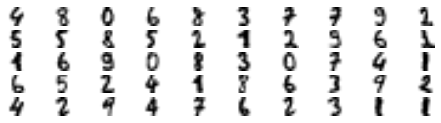

Figure 9-13


In [42]:
plt.figure(figsize=(8, 2))

for i, digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, i + 1 )
    plt.imshow(digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis("off")

save_fig("Clustering - KMeans, Semi-supervised learning with digits", tight_layout=False)
plt.show()
print("Figure 9-13")

Let's look at each image and manually label it

In [43]:
y_train[representative_digit_idx]

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

In [44]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1
])

Now there's a dataset with 50 labeled instances, but instead of completely being random, each of them is a representative image of its cluster. Let's see if the performance is better

In [46]:
log_reg_semi = LogisticRegression(multi_class="ovr", solver="lbfgs",
                                  max_iter=5000, random_state=42)
log_reg_semi.fit(X_representative_digits, y_representative_digits)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [47]:
log_reg_semi.score(X_test, y_test)

0.9222222222222223

That's good news, from 83.3% accuracy to 92.2%, although the training is only been done on 50 instances. Since its costly to manually label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances

Next, ***label propogation*** should be a good idea. That is, propogating the labels to all the other instances that are in the same cluster

In [52]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans_semi.labels_==i] = y_representative_digits[i]

In [56]:
log_reg_semi = LogisticRegression(multi_class="ovr", solver="lbfgs",
                                  max_iter=5000, random_state=42)
log_reg_semi.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [57]:
log_reg_semi.score(X_test, y_test)

0.9333333333333333

A reasonable accuracy boost. We should probably had propagated the labels only to instances closest to the centroid, because by propagating to the whole cluster, we have clearly mislabeled instances close to the boundries of the cluster.

Let's propagate the labels to the 75th percentile closest to the centroid

In [58]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans_semi.labels_]
for i in range(k):
    in_cluster = (kmeans_semi.labels_==i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist> cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [59]:
partially_propogated = (X_cluster_dist != -1)
X_train_partially_propogated = X_train[partially_propogated]
y_train_partially_propogated = y_train_propagated[partially_propogated]

In [60]:
log_reg_semi = LogisticRegression(multi_class="ovr", solver="lbfgs",
                                 max_iter=5000, random_state=42)
log_reg_semi.fit(X_train_partially_propogated, y_train_partially_propogated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [61]:
log_reg_semi.score(X_test, y_test)

0.9355555555555556

The score is a bit better than before (93.33%). With just 50 labeled instances 
(just 5 examples per class on average), we got 93.35% performance, which is getting closer to the performace of Logistic Regression on the fully labeled digits dataset (96.88%).

This is because the propagated labels are actually pretty good. their accuracy is close to 97%

In [62]:
np.mean(y_train_partially_propogated == y_train[partially_propogated])

0.9750747756729811

## DBSCAN

**DBSCAN** algorithm defines clusters as continuous regions of high density. It works in the following manner:
- For each instance, the algorithm counts how many other instances are located within a small distance $\epsilon$ from it. This region is called the instances $\epsilon$_-neighborhood_.
- If an instances has at least **min_samples** instances in its $\epsilon$-neighborhood (including itself), then its considered a **core instance**. That is, **core instances** are those that're located in dense regions.
- All instances in the neighborhood of a **core instance** belong to the same cluster. This neighborhood may include multiple core instances; therefore, **a long sequence of neighboring core instances forms a single cluster**. 
- Any instance that isn't a **core instance** and doesn't have any one in it's neighborhood is considered an anomlay.

This algorithm **works well if all the clusters are dense enoguh and if they're well separated by low-density regions**.

In [73]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [74]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

Let's check the labels and the assigned labels of the first 10 instances

In [75]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

In [81]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

Some instances have a cluster index of -1, which means that they're considered anomalies.

The **indices of the core instances**:

In [76]:
len(dbscan.core_sample_indices_)

808

In [80]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

The **core instances** themselves:

In [79]:
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

The following figure 9-14 compares between 2 degrees of **eps**: 0.05 and 0.2. 

In [84]:
dbscan2 = DBSCAN(eps=0.2, min_samples=5)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [97]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_ ,dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)
    
    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1], c=dbscan.labels_[core_mask], s=size,
                marker="o", cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], c=dbscan.labels_[core_mask], s=20,
               marker="*")
    plt.scatter(anomalies[:, 0], anomalies[:, 1], c="r", s=100, marker="x")
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask],
                marker=".")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else: 
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0, fontsize=14)
    else:
        plt.tick_params(labelleft=False)
        
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples),
             fontsize=14)

Saving figure, Clustering - KMean, DBSCAN plotting with 2 different epsilons


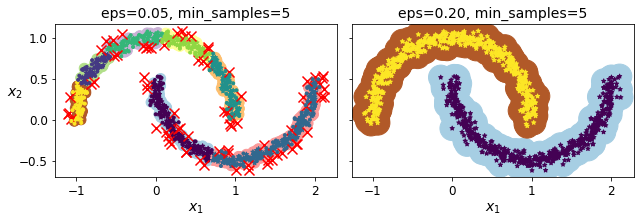

Figure 9-14


In [98]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("Clustering - KMean, DBSCAN plotting with 2 different epsilons")
plt.show()
print("Figure 9-14")

As we can see, when **eps=0.05** DBSCAN identifies quite a few anomalies and makes more clusters. If we widen each instance neighborhood by setting **eps=0.2**, we get the plot on the right

**DBSCAN doesn't have a predict() method**, it has a **fit_predict() method instead**. That is, it can't predict which cluster a new instance belongs to. We can incorporate different classification algorithms that can perform a better job of predicting

In [100]:
#Reset dbscan to the model that performed better (eps=0.2)
dbscan = dbscan2

In [103]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

Given a few new instances, we can predict which clusters they most likely belong to and estimate a probability for each cluster

In [104]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [105]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

**Note** we only trained it on the core instances, but we could've trained it on all the instances, or all but the anomalies - this depends on the final task

The decision boundary is represented on figure 9-15, the crosses are the 4 new instances. 

Since there are no anomalies in the training set, the classifier always chooses a cluster, **even when its far away**. We can introduce a maximum distance, in which case the two instances that are far away are classified as anomalies. 

<ipython-input-19-50808b416ee9>:22: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1,


Saving figure, Clustering - KMean, DBSCAN with KNN predict


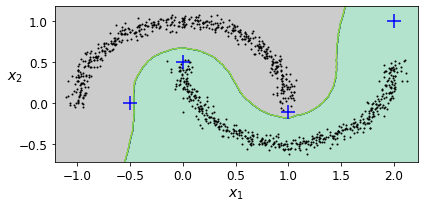

Figure 9-15


In [110]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", s=200, zorder=10, marker="+")
save_fig("Clustering - KMean, DBSCAN with KNN predict")
plt.show()
print("Figure 9-15")

We'll use the **kneighbors()** method of KNeighborsClassifier classify the distant instances as anomalies. Given a set of instances, it returns the distances and indices of the $k$ nearest neighbors in the training set (2 matrices, each with $k$ columns)

In [111]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)

DBSCAN is a powerful algorithm capable of identifying any number of clusters of any shape. It can deal with outliers, and it just has 2 hyperparameters (**eps** and **min_samples**). However, it will be impossible to capture all the clusters properly if the density varies significantly across the clusters.

The computational complexity is around $O(mlogm)$, which is pretty close to linear with regard to the number of instances, **but Scikit Learn's implementation can require up to $O(m^2)$ memory if _eps_ is large.**

## Other clustering algorithms

- Agglomerative clustering
    - A heirarchy of clusters is built from the bottom up. Like many tiny bubbles floating on water and gradually attaching to each other until there's one big group of bubbles. Similarly, at each iteration, **agglomerative clustering** connects the nearest pair of clusters (starting with individual instances). If you drew a tree with a branch for every pair of clusters that merged, you would get a binary tree of clusters, where the leaves are the individual instances. This approach scales very well to large numbers of instances or clusters. 
    
    It can catch clusters of various shapes, it produces a flexible and informative cluster tree instead of forcing you to choose a particular cluster scale, and it can be used with any pairwise distance. It can scale nicely to large numbers of instances if you provide a connectivity matrix, which is a sparse $m \times m$ matrix that indicates which pairs of instances are neighbors (e.g returned by **sklearn.neighbors.kneighbors_graph())**. Without a connectivity matrix, the algorithm doesn't scale well to large datasets.


- BIRCH 
    - THe BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) algorithm was specifically designed gor very large datasets, and it can be faster than batch K-Means, with similar results, as long as the number of features isn't too large (<20). During training, it builds a tree structure containing just enough information to quickly assign a new instance to a cluster, without having to store all the instances in the tree: this approach allows it to use limited memory, while handling huge datasets.
  
  
- Mean-Shift
    - This algorithm starts by placing a circle around each instance; then for each circle it computes the mean of all the instances located within it, and it shifts the circle so that it will be centered to the mean. Next, it iterates this mean-shifting step until all the circles stop moving. **Mean-Shifts** shifts the circles in the direction of higher density, until each of them has found a local density maximum. Finally, all the instances whose circles have settled in the same place (or close by) are assigned to the same cluster. 
    
    **Mean-Shift** and DBSCAN share some features, both can find any number of clusters of any shape, and they have very few hyperparameters (**Mean-Shift** has only one - ***bandwidth**, which is the radius of the circles) and they rely on local density estimation. But unlike DBSCAN, **Mean-Shift** tends to chop clusters into pieces when they have internal density variations. Unfortunately, it's computational complexity is $O(m^2)$, thus it's not suited for large datasets.


- Affinity propagation
    - This algorithm uses a voting system, where instances vote for similar instances to be their representatives, and once the algorithm converges, each representative and its voters form into a cluster. **Affinity propagation** can detect any number of clusters of different sizes. Unfortunatelu, it's computational complexity is $O(m^2)$, so it too can deal with large datasets.

    
- Spectral clustering
     - This algorithm takes a similarity matrix between the instances and creates a low-dimensional embedding from it (i.e, it reduces its dimensionality), then it uses another algorithm in this low-dimensionality space (Scikit Learn's implementation uses K-Means). Spectral clustering can capture complex cluster structures, and it can also be used to cut graphs (e.g, to identify clusters of friends on a social network). Unfortunately, it doesn't scale well to large numbers of instances, and it doesn't behave well when the clusters have very different sizes.

Let's implement **Agglomerative clustering**

In [129]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [132]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [133]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [134]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

Let's implement **Spectral clustering**

In [113]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [114]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [115]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [121]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True,
                             show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker="o", c="gray", s=size, cmap="Paired",
                alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker="o", c="w", s=30)
    plt.scatter(X[:, 0], X[:, 1], marker=".", c=sc.labels_, s=10, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0, fontsize=14)
    else:
        plt.tick_params(labelleft=False)
    
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

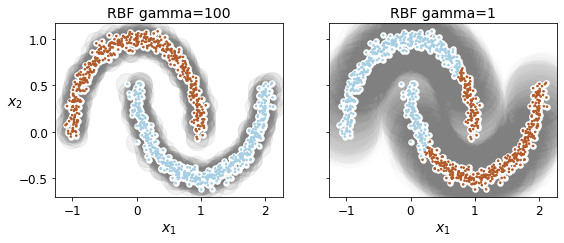

In [122]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

# End Of Section: Clustering

# Section: Gaussian Mixtures

**Gaussian mixture model (GMM)** is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. A single Gaussian distribution form a cluster that looks like an ellipsoid. Each ellipsoid can have a different shape, size, density and orientation. 

You can't infer from which Gaussian distribution an instances was generated, nor the parameters of the distribution.

There are several variants to **GMM**. The most basic form, GaussianMixture class, requires from you to know the number $k$ of Gaussian distributions. 

The dataset $X$ is assumed to have been generated through the following probabilistic process:

- For each instance, a cluster is picked randomly from among $k$ clusters. The probability of choosing the $j^{th}$ cluster is definied by the cluster's weight, $\phi^{(j)}$. The index of the cluster chosen for the $i^{th}$ instance is noted $z^{(i)}$.
- if $z^{(i)=j}$, meaning the $i^{(th)}$ instance has been assigned to the $j^{(th)}$ cluster, the location $x^{(i)}$ of this instance is sampled randomly from the Gaussian distribution with mean $\mu^{(j)}$ and covariance matrix $\Sigma^{(j)}$. This is noted $x^{(i)} \sim \mathcal{N}(\mu^{(j)},\sum^{(j)})$.

Figure 9-16 represents a graphical model of the generative process. In it, the structure of the conditional dependencies between random variables

<img src="images/Clustering - Gaussian mixture model.png">

In the figure you'll find:
- The circles represent random variables
- The squares represent fixed values (i.e, parameters of the model)
- The large rectangles are called _plates_. They indicate that their content is repeated several times
- The number at bottom right of each plate (m, k) indicates how many times its content is repeated. So, there are _m_ random variables $z^{(i)}$ ($z^{(1)}$ to $z^{(m)}$) and $x^{(i)}$. Also, there are _k_ means $\mu^{(j)}$ and _k_ covariance matrices $\Sigma^{(j)}$. 
Lastly, there is just one weight vector $\phi$ (containing all the weights $\phi^{(1)}$ - $\phi^{(k)}$)
- Each variable **$z^{(i)}$ is drawn from the categorical distribution** with weights $\phi^{(1)}$. Each variable **$x^{(i)}$ is drawn from the normal distribution**, with the mean and covariance matrix definied by its cluster $z^{(i)}$
- The solid arrows represent conditional dependencies. For example, the probability distribution for each random variable $z^{(i)}$ depends on the weight vector $\phi$.
    - Note, when an arrow crosses a plate boundary, it means that it applies to all the repetitions of that plate. For example, the weight vector $\phi$ conditions the probability distribution of all the random variables $x^{(1)}$ to $x^{(m)}$
- The squiggly line arrow from $z^{(i)}$ to $x^{(i)}$ represents a switch: depending on the value of $z^{(i)}$, the instance $x^{(i)}$ will be sampled from a different Gaussian distribution. For example, if $z^{(i)}=j$, then $x^{(i)} \sim \mathcal{N}(\mu^{(j)},\sum^{(j)})$
- Shaded nodes indicate that the value is known. In this case, only the random variables $x^{(i)}$ have known values: they are called _observed variables_. The unknown random variables $z^{(i)}$ are called _latent variables_.

So, what can you do with such a model? Well, given the dataset $X$, you typically want to **start by estimating the weights $\phi$ and all the distribution parameters $\mu^{(1)}$ to $\mu^{(k)}$ and $\Sigma^{(1)}$ to $\Sigma^{(k)}$**.

In [36]:
X1, y1 = make_blobs(n_samples=1000, centers=([4, -4], [0, 0]), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [37]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [38]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [39]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [40]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

This class relies on the ***Expectation-Maximization (EM)*** algorithm, which is similar to K-Means: 
- Cluster parameters are initalized randomly
- The it repeates two steps until convergence
    - First, assigning instances to clusters (called ***expectation step***)
    - Then, updating the clusters (called ***maximization step***)
    
**In the context of clustering, EM can be a generalization of K-Means that finds clusters center ($\mu^{(1)}$ to $\mu^{(k)}$), but also their size, shape, orientation ($\Sigma^{(1)}$ to $\Sigma^{(k)}$) and relative weights ($\phi^{(1)}$ to $\phi^{(1)}$).**

**Unlike K-Means, EM uses soft cluster assignments**. For each instance during the **expectation step**, the algorithm estimates the probability that it belongs to each cluster. Then during the **maximization step**, each cluster is updated using _all_ the instances in the dataset, with each instance weighted by the estiamted probabilty that it belongs to that clsuter.

This probabilities are called the ***responsibilities*** of the clusters for the instances.

During the ***maximization step***, each cluster's update will mostly be impacted by the instances it's most responsible for.

Has the algorithm converge?

In [41]:
gm.converged_

True

How many iteration did it take to converge?

In [42]:
gm.n_iter_

4

After estimating the location, size, shape, orientation and relative weight of each clsuter, the model can predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster.

In [43]:
#Hard clustering
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2], dtype=int64)

In [44]:
#Probabilites
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

A gaussian mixture model is a ***generative model***, meaning that it's possible to sample new instances from it (ordered by cluster index)

In [45]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [46]:
y_new

array([0, 0, 1, 2, 2, 2])

As you can see they're sampled sequentially from each other.

It's also possible to estimate the density of the model at any given location. This is achieved using the ***score_samples()*** method: for each instance it's given, this method estimates the log of the ***probability density function*** (PDF) at that location. The greater the score, the higher the density

In [47]:
gm.score_samples(X)

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

Let's check that the PDF integrates to 1 over the whole space. We:
- take a large square around the clusters
- Then chop it into a grid of tiny squares
- After that, compute the approximate probability that the instances will be generataed in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square)
- Finally, summing all these probabilities 

The result is very close to 1

In [48]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) **2
pdf_probas.sum()

0.9999999999215021

Next, plot the resulting decision boundaries (dashed lines) and density contours

In [49]:
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabel=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z,
            norm=LogNorm(vmin=1.0, vmax=30.0),
            levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
           norm=LogNorm(vmin=1.0, vmax=30.0),
           levels=np.logspace(0, 2, 12),
           linewidths=1, colors="k")
    
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z,
                linewidths=2, colors="r", linestyles="dashed")
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)
    
    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabel:
        plt.ylabel("$x_2$", rotation=0, fontsize=14)
    else:
        plt.tick_params(labelleft=False)

Saving figure, Clustering - Gaussian mixture, cluster means, decision boundaries and density contours


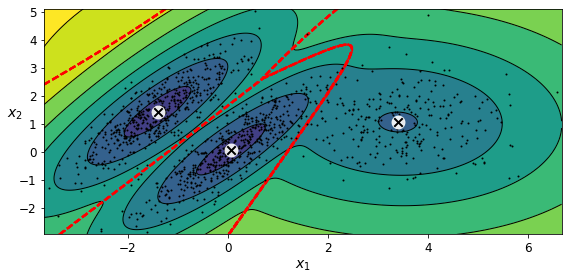

Figure 9-17


In [50]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm,X)
save_fig("Clustering - Gaussian mixture, cluster means, decision boundaries and density contours")
plt.show()
print("Figure 9-17")

The algorithm found an excellent solution. We made the task easy by generating the data using a set of 2D Gaussian distributions (real life data isn't so Gaussian and low-dimensional). Also, the algorithm has been given the correct number of clusters. When there are many dimensions, or many clusters, or few instances, EM can struggle to converge to the optimal solution.

Reducing the difficulty of the task by limiting the number of parameters that the algorithm has to learn might help. One way to do this is to limit the range of shapes and orientations that the clusters can have. This can be achieved by imposing constaraints on the covariance matrices. To do this, we can set the **covariance_type** hyperparameter:
- "full"(default) - no constraint, all clusters can take on any ellipsoidal shape of any size
- "tied" - all clusters must have the same shape, which can be any ellipsoid (i.e, they all share the same covariance matrix)
- "spherical" - all clusters must be spherical, but they can have different diameters (i.e, different variances)
- "diag" - clusters can take on any ellipsoidal shape of any size, but the ellopsoids axes must be parallel to the axes (i.e, the convariance matrices must be diagonal)

In [51]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full",
                          random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied",
                         random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical",
                              random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag",
                         random_state=42)

gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [52]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9,4))
    
    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title("covariance_type={}".format(gm1.covariance_type), fontsize=14)
    
    plt.subplot(122)
    plot_gaussian_mixture(gm2, X)
    plt.title("covariance_type={}".format(gm2.covariance_type), fontsize=14)

Saving figure, Clustering - Gaussian mixture, different covariance types: tied vs spherical


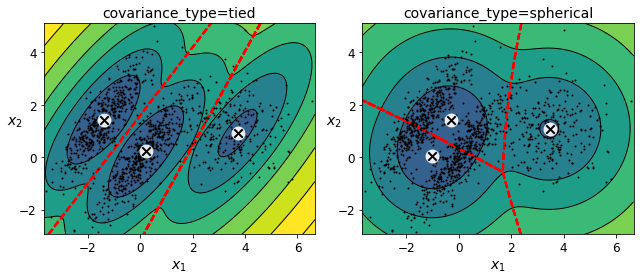

Figure 9-18a


In [53]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
save_fig("Clustering - Gaussian mixture, different covariance types: tied vs spherical")
plt.show()
print("Figure 9-18a")

Saving figure, Clustering - Gaussian mixture, different covariance types: full vs diag


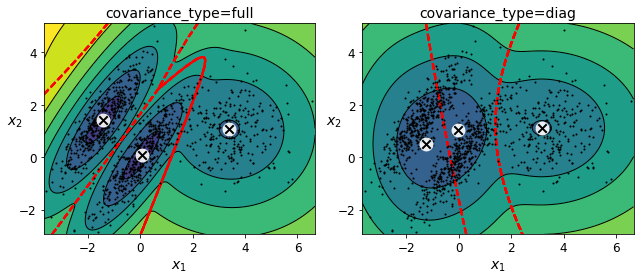

Figure 9-18b


In [54]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
save_fig("Clustering - Gaussian mixture, different covariance types: full vs diag")
plt.show()
print("Figure 9-18b")

> The computational complexity of training a GaussianMixture model depends on the number of instances _m_, the number of dimensions _n_, the number of clusters _k_, and the constraints on the covariance matrices. If covariance_type is "spherical" or "diag", its $O(kmn)$, assuming the data has a clustering structure. If covariance_type is "full" or "tied", its $O(kmn^2 + kn^3)$, so it won't scale to large number of features

## Anomaly detection using Gaussian mixtures

Gaussian Mixtures can be used for _anomaly detection_: instances located in a low-density region can be considered as anomalies. You must define what density thershold you want to use. For instance, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well known. Say its 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density

In [55]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

Saving figure, Clustering - Gaussian mixture, anomaly detection


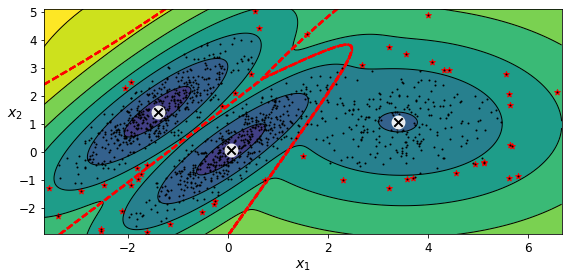

Figure 9-19


In [56]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color="r", marker="*")
plt.ylim(top=5.1)

save_fig("Clustering - Gaussian mixture, anomaly detection")
plt.show()
print("Figure 9-19")

A related task is **novelty detection**: it differs from anomaly detection in that the algorithm is assumed to be trained on a "clean" dataset, uncontaminated by outliers, whereas anomaly detection doesn't make this assumption. Outlier detection is often used to clean up a dataset.

> Gaussian mixtures try to fit all the data, including the outliers, so having to many of them might bias the model's view of "normality", and some outliers might be wrongly considered as normal. If it happens, you can try to fit the model ones, use it to detect and remove the most extreme outliers, then fit the model again on the cleaned-up dataset. 

## Selecting the number of clusters

With K-Means, you could use the inertia or the silhouette score to select the appropriate number of clusters. With Gaussian Mixtures, it's not possible to use both because they assume that the clusters are spherical. Instead, it's possible to find the model that minimizes a _theoretical information criterion_, such as the _Bayesian information creterion_ (BIC) or the _Alkaike information criterion_ (AIC)

<img src="images/Clustering - Gaussian mixture, Bayesian and Akaike infromation criterions.png">

- $m$ = number of instances
- $p$ = number of parameters learned by the model
- $\hat{L}$ = the maximized value of the _likelihood function_ of the model (gm.score(X) * len(X))

Both the BIC and AIC penalize models that have more parameters to learn (e.g, more clusters) and reward models that fit the data well. They often end up selecting the same model. When they differ, the model selected by the BIC tends to be simpler (fewer parameters) that the one selected by the AIC, but tends to not fit the data quite as well (especially for larger datasets)

#### Likelihood function

> The terms "likelihood" and "probability" are often used interchangeably, but they have different meaning in statistics. Given a statistical model with some parameters $\theta$:
- The word "probability" is used to describe how plausible a future outcome $x$ is (knowing the parameters of $\theta$)
- While the "likelihood" is used to describe how plausible a particular set of parameters values $\theta$ are, after the outcome $x$ is known


Let's illustrate this on the following figure 9-20. For instance, let's take a 1D mixture model of 2 Gaussian distributions centered at -4 and +1 with a signle parameter $\theta$ that controls the standard deviations of both distributions. 

On the top left plot you can see the entire model $f(x;\theta)$ as a function of both $x$ and $\theta$. To estimate the probability distribution of a future outcome $x$, you need to set the model parameter $\theta$. 

For example, setting $\theta$ to 1.3 (the horizontal lien), you get the probability density function $f(x; \theta=1.3)$ shown in the lower left plot. If you want to estimate the probability that $x$ will fall between -2 and +2, you must calculate the integral PDF on this range (i.e, the surface of shaded region).

But what if you don't know $\theta$, and instead you have observed a single instance $x=2.5$ (upper left plot)? This will result in a likelihood function $\mathcal{L}(\theta|x=2.5) = f(x=2.5; \theta)$ (upper right plot) 

In [72]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

Saving figure, Clustering - Gaussian mixture, Likelihood function plot


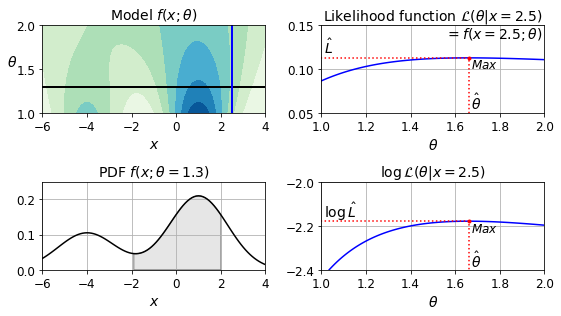

Figure 9-20


In [73]:
plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

save_fig("Clustering - Gaussian mixture, Likelihood function plot")
plt.show()
print("Figure 9-20")

To sum, **PDF is a function of $x$ (with $\theta$ fixed), while the likelihood function is a function of $\theta$ (with $x$ fixed)**. 
The likelihood function **isn't a probability distribution** if you integrate a probabilty distribution over all possible values of $x$, you always get 1; but if you integrate the likelihood function over all possible values of $\theta$, the result can be any positive number.

Given a dataset $X$, a common task is to try to estimate the most likely values for the model parameters. To do this, you must find the values that maximize the likelihood function, given $X$. From the above example, if you have observed a single instance $x=2.5$, the _maximum likelihood estimate_ (MLE) of $\theta$ is $\hat{\theta} = 1.5$. 

If a prior probability distribution $g$ over $\theta$ exists, its possible to take into account by maximizing $\mathcal{L}(\theta|x)g(\theta)$ rather than just maximizing $\mathcal{L}(\theta|x)$, also called the _maximum a-posteriori_ (MAP) estimation. Since MAP constraints the parameter values, it's like a regularized version of MLE.

Maximizing the likelihood function is equivalent to maximizing it logarithm (lower right plot). Logarithm is a strictly increasing function, so if $\theta$  maximizes the log likelihood, it also maximizes the likelihood. It's generally easier to maximize the log likelihood. <br>
For example, observing several independent instances $x^{(1)}$ to $x^{(m)}$, you would need to find the value of $\theta$ that maximizes the product of the individual likelihood functions. But its equivalent, to maximizing the sum of the log likelihood functions, due to the logarithm which converts products into sums: $\log(ab)=\log(a)+\log(b)$.

Once you have achieved estimated $\hat{\theta}$, the value of $\theta$ that maximizes the likelihood function, then you can compute $\hat{L} = \mathcal{L}(\hat{\theta},X)$, which is the value used to compute the AIC and BIC, you can think of it as a measure of how well the model fits the data

To compute the BIC and AIC:

In [75]:
gm.bic(X)

8189.747000497186

In [76]:
gm.aic(X)

8102.521720382148

We could compute the BIC manually:

In [77]:
n_clusters= 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2 #Degrees of freedom for an nxn covariance matrix
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) #log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [78]:
bic, aic

(8189.747000497186, 8102.521720382148)

In [79]:
n_params

17

There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. Similarly, the degrees of freedom for an $n \times n$ covariance matrix isn't $n^2$, but $1 + 2 + ... + n = \frac{n(n+ 1)}{2}$

Let's train a Gaussian mixture models and train it with various values for $k$ and measuer the BIC

In [80]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
            for k in range(1, 11)]

In [81]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

Saving figure, Clustering - Gaussian mixture, AIC and BIC for different numbers of k


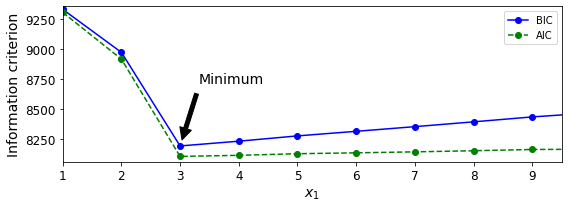

Figure 9-21


In [82]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("Information criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics)-50, np.max(aics)+50])
plt.annotate("Minimum", xy=(3, bics[2]), xytext=(0.35, 0.6),
             textcoords="figure fraction", fontsize=14,
             arrowprops=dict(facecolor="black", shrink=0.1))
plt.legend()

save_fig("Clustering - Gaussian mixture, AIC and BIC for different numbers of k")
plt.show()
print("Figure 9-21")

As we can see both AIC and BIC are lowest when $k=3$, thus its most likely the best choice

Let's search for the best value for the **covariance_type** hyperparameter

In [83]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10, random_state=42,
                            covariance_type=covariance_type).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [84]:
best_k

3

In [85]:
best_covariance_type

'full'

## Bayesian Gaussian mixture models

Rather than manually searching for the optimal number of clusters, it's possible to use instead the BayesianGaussianMixture class which is capable of giving weights (or close) to zero to unnecessary clusters. Just set the number of components to a value that you think is greater than the optimal number of clusters, and the algorithm will eliminate the unnecessary clusters automatically

In [86]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

The algorithm automatically detected that only 3 components are needed

In [87]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

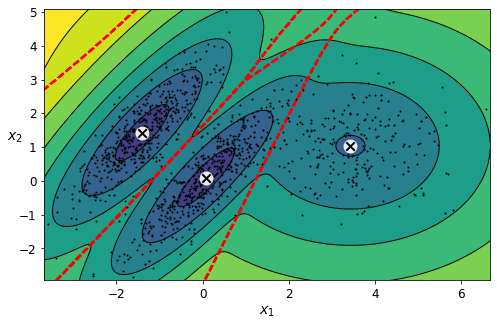

In [88]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In this model, the cluster parameters (including weights, means and covariance matrices) aren't treated as fixed model parameters anymore, but as latent random variables, like the cluster assignments. So $z$ now includes both the cluster parameters and the cluster assignments

The Beta distribution is commonly used to model random variables whose values lie within a fixed range. In this case, the range is between 0 to 1.

The Stick-Breaking Process (SBP) is best explaned with an example:

Assume $\phi$=[0.3, 0.6, 0.5, ...], the 30% of the instances will be assigned to cluster 0, 60% to cluster 1 and so on. **This process is a good model for datasets where new instances are more likely to join large clusters than small clusters (e.g, people are more likely to move to larger cities)**. 

- If the concentration $\alpha$ is high, then $\phi$ values will likely be close to 0 and the SBP generate many cluster.
- On the other hand, if the concentration of $\alpha$ is low, then $\phi$ values will likely be close to 1, and there will be fewer clusters.
- Finally, the Wishart distribution is used to sample covariance matrices: 
    - The parameter **d** and **v** control the distribution of cluster shapes.

<img src="images/Clustering - Bayesian Gaussian mixture model.png">

Prior knowldege about the latent variables $z$ can be encoded in a probability distribution $p(z)$ called ***prior***. For example, we may have a prior belief that the clusters are likely to be few (low concentration), or plentiful (high concentration). **This prior belief about the number of clusters can be adjusted using the _weight_concentration_prior hyperparameter_**. Figure 9-23 shows how setting it to different values can result in very different clusterings. **However, the more data there is, the less the priors matter**. In fact, to plot diagrams with such large differences, you must use very strong priors and little data

In [89]:
bgm_low = BayesianGaussianMixture(n_components=10, n_init=1, max_iter=1000,
                                 weight_concentration_prior=0.01,
                                 random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, n_init=1, max_iter=1000,
                                  weight_concentration_prior=10000,
                                  random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [90]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [91]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

Saving figure, Clustering - Bayesian Gaussian mixture, different concentration priors on the same data


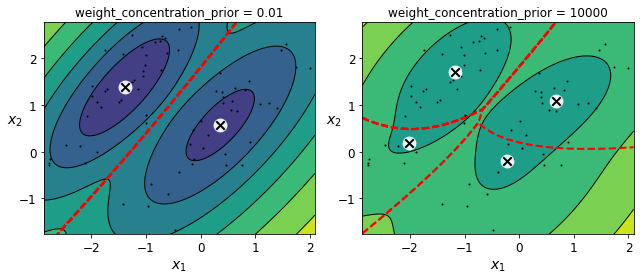

Figure 9-23


In [92]:
plt.figure(figsize=(9,4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = {}".format(bgm_low.weight_concentration_prior))

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn])
plt.title("weight_concentration_prior = {}".format(bgm_high.weight_concentration_prior))

save_fig("Clustering - Bayesian Gaussian mixture, different concentration priors on the same data")
plt.show()
print("Figure 9-23")

Bayes' Theorem tells us how to update the probability distribution over the latent variables after we observe some data $X$. it computes the ***posterior*** distribution $p(z|X)$, which is the conditional probablity of $z$ given $X$

<img src="images/Bayes' theorem.png">

Unfortunately, in Gaussian mixture model (and many other problems), the denominator $p(x)$ is intractable, as it requires integrating over all the possible values of $z$, which would require considering all possible combinations of cluster parameters and cluster assignment

<img src="images/Gaussian mixture model, intratability problem.png">

This intractability is one of the central problems in Bayesian statistics, and there are several approaches to solving it. One of them is **variational inference**:
- It picks a family of distributions $q(z; \lambda)$ with its own **variantional parameters** $\lambda$
- Then, optimizes these parameters to make $q(z)$ a good approximation of $p(z|X)$. 
- This is achieved by finding the value of $\lambda$  that minimizes the KL divergence from $q(z)$ to $p(z|X)$, noted $D_k(q||p)$.

The KL divergence equation is shown below, and it can be rewritten as the log of the evidence ($log(p(X))$) minus the **evidence lower bound** (ELBO). Since the log evidence doesn't depend on $q$, it's a constant term, so minimizing the KL divergence just requires maximizing the ELBO

<img src="images/KL divergence equation.png">

Gaussiam mixtures work great on clusters with an ellipsoidal shape, but if trying to fit a dataset with different shapes, you won't get good results. An example in figure 9-24 shows what happens when using Bayesian mixture model to cluster the moons dataset

In [93]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [94]:
bgm = BayesianGaussianMixture(n_components=10, n_init=1, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, random_state=42)

Saving figure, Clustering - Bayesian Gaussian mixture, fitting BGM to non-ellipsoidal clusters


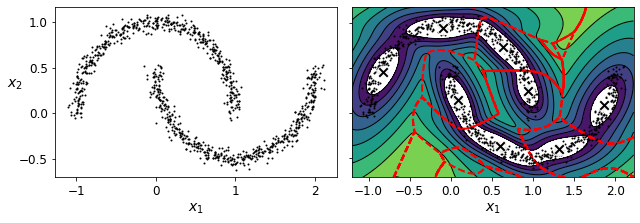

Figure 9-24


In [95]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", rotation=0, fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabel=False)

save_fig("Clustering - Bayesian Gaussian mixture, fitting BGM to non-ellipsoidal clusters")
plt.show()
print("Figure 9-24")

As you can see, the algorithm tried to search for ellipsoids, so it found more than 2 clusters. However, the density estimation isn't too bad, so this model might be usable for anomaly detection

## Other algorithms for anomaly and novelty detection

- PCA (and other dimnesionality reduction techniques with an _inverse_transform()_)
    - If you compare the reconstruction error of a normal instance with the reconstruction error of an anomaly, the latter will usually be larger. This is a simple and often quite efficient anomaly detection approach.
    
- Fast-MCD (minimum covariance determinant)
    - Implemented by the EllipticEnvelope class, this algorithm is useful for outlier detection, in particular to clean up a dataset. It assumes that the normal instances (inliers) are generated from a single Guassian distribution (not a mixture). It also assumes that the data is contaminated with outliers that weren't generated from this Gaussian distribution. When the algorithm estimates the parameters of the Gaussian distribution (i.e, the shape of the elliptic envelope around the inliers), it's careful to ignore the instances that are more likely to be outliers. This technique gives a better estimation of the elliptic envelope and this makes the algorithm better at identifying the outliers.
    
- Isolation Forest
    - An efficient algorithm for detecting outliers, especially in high-dimensional datasets. The algorithm builds a Random Forest in which a Decision Tree is grown randomly: at each node it picks a node randomly, then it picks a random threshold value (between min and max values) to split the dataset in 2. The dataset gradually gets chopped into pieces this way, until all instances end up isolated from other instances. Anomalies are usually far from other instances, so on average (across all Decision Trees) they tend to get isolated in fewer steps than normal instances.
    
- Local Outlier Factor (LOF)
    - Also a suited algorithm for outliers. It compares the density of instances around a given instance to the density around its neighbors. An anomaly is often isolated than its $k$ nearest neighbors.
    
- One Class SVM
    - An algorithm that is better suited for novelty detection. Remember that a kernelized SVM classifier separates two classes by first (implicitly) mapping all the instances to a high-dimensional space, then separating the two classes using a linear SVM classifier within this high-dimensional space. Since we just have one class of instances, the One Class SVM algorithm instead tries to separate the instances in high-dimensional space from the origin. 
    
    In the original space, this will correspind into finding a small region that encompases all the instances. If a new instance doesn't fall within this region, it's an anomaly. The hyperparameters are the same as the kernelized SVM in addition, a margin hyperparameter that corresponds to the probability of a new instance being mistakenly considered as a novel when it's fact normal. It's especially effective in high-dimensional datasets, but like all SVMs it doesn't scale to large datasets.

# End Of Section: Gaussian Mixture

# Section: Exercise Solutions

##### See appendix A for solutions: Questions 1-9

### 10

The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the sklearn.datasets.fetch_olivetti_faces() function, then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set. Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter). Visualize the clusters: do you see similar faces in each cluster?

Let's solve the questions:
- The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the _sklearn.datasets.fetch_olivetti_faces()_ function

In [2]:
olivetti = fetch_olivetti_faces()

In [3]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [4]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

- Then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set.

In [5]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=42)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [11]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


We'll use PCA to reduce the dimensionality, which will speed things up

In [60]:
pca = PCA(0.99) #Preserve 99% of the variance
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

200

- Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter)

In [14]:
k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


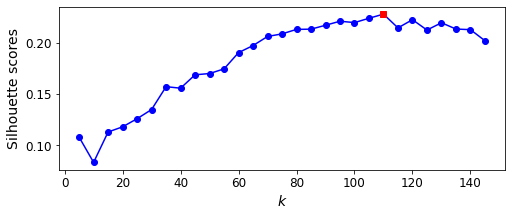

In [17]:
silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                    for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette scores", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [18]:
best_k

110

110 clusters is a bit high. Considering the fact that there are 40 people, you would expect to get 40 as the best number for clsuters. Yet, the same person may look different on different pictures; with glasses or without or perhaps shifted left or right

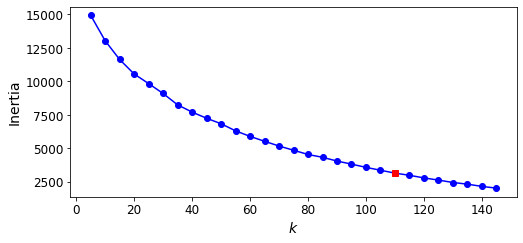

In [24]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

When using PCA to find the best $k$, where looking for an elbow in the graph. Yet in this graph, there isn't any clear elbows, thus we'll stick with k=100

In [26]:
best_model = kmeans_per_k[best_index]

-  Visualize the clusters: do you see similar faces in each cluster?

Cluster: 0


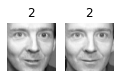

Cluster: 1


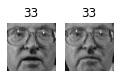

Cluster: 2


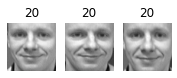

Cluster: 3


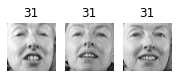

Cluster: 4


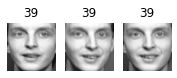

Cluster: 5


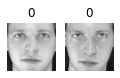

Cluster: 6


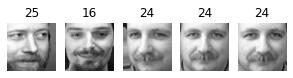

Cluster: 7


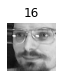

Cluster: 8


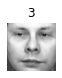

Cluster: 9


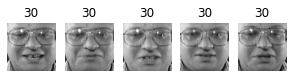

Cluster: 10


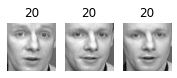

Cluster: 11


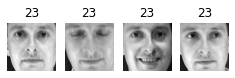

Cluster: 12


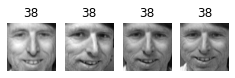

Cluster: 13


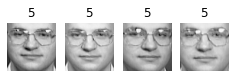

Cluster: 14


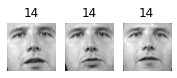

Cluster: 15


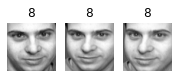

Cluster: 16


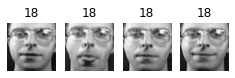

Cluster: 17


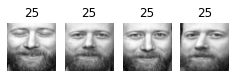

Cluster: 18


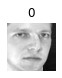

Cluster: 19


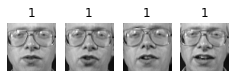

Cluster: 20


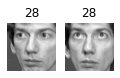

Cluster: 21


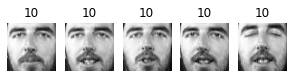

Cluster: 22


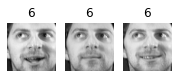

Cluster: 23


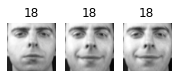

Cluster: 24


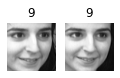

Cluster: 25


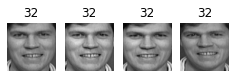

Cluster: 26


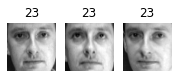

Cluster: 27


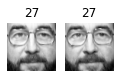

Cluster: 28


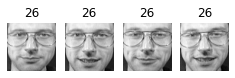

Cluster: 29


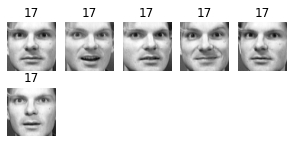

Cluster: 30


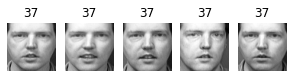

Cluster: 31


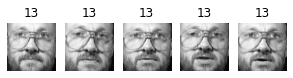

Cluster: 32


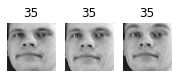

Cluster: 33


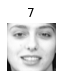

Cluster: 34


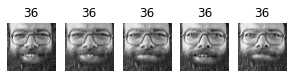

Cluster: 35


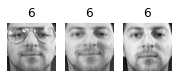

Cluster: 36


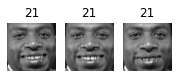

Cluster: 37


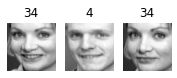

Cluster: 38


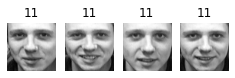

Cluster: 39


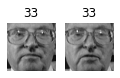

Cluster: 40


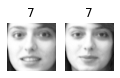

Cluster: 41


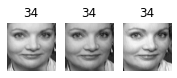

Cluster: 42


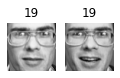

Cluster: 43


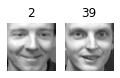

Cluster: 44


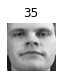

Cluster: 45


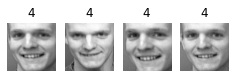

Cluster: 46


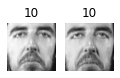

Cluster: 47


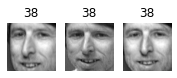

Cluster: 48


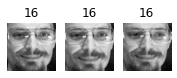

Cluster: 49


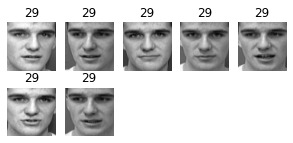

Cluster: 50


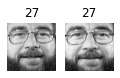

Cluster: 51


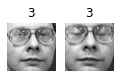

Cluster: 52


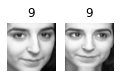

Cluster: 53


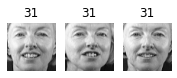

Cluster: 54


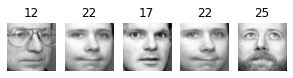

Cluster: 55


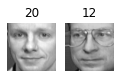

Cluster: 56


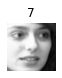

Cluster: 57


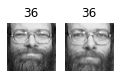

Cluster: 58


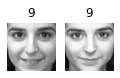

Cluster: 59


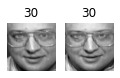

Cluster: 60


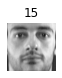

Cluster: 61


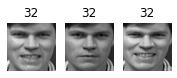

Cluster: 62


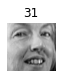

Cluster: 63


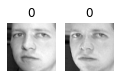

Cluster: 64


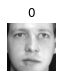

Cluster: 65


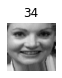

Cluster: 66


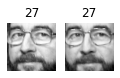

Cluster: 67


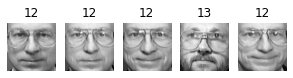

Cluster: 68


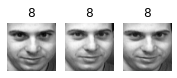

Cluster: 69


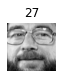

Cluster: 70


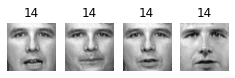

Cluster: 71


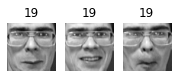

Cluster: 72


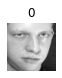

Cluster: 73


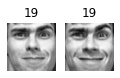

Cluster: 74


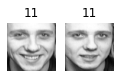

Cluster: 75


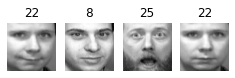

Cluster: 76


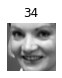

Cluster: 77


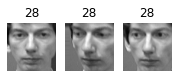

Cluster: 78


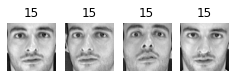

Cluster: 79


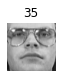

Cluster: 80


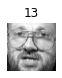

Cluster: 81


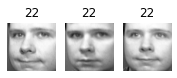

Cluster: 82


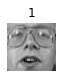

Cluster: 83


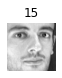

Cluster: 84


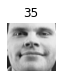

Cluster: 85


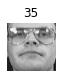

Cluster: 86


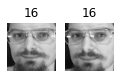

Cluster: 87


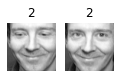

Cluster: 88


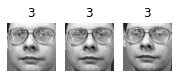

Cluster: 89


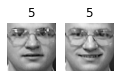

Cluster: 90


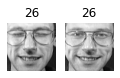

Cluster: 91


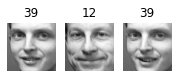

Cluster: 92


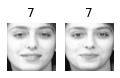

Cluster: 93


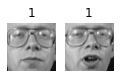

Cluster: 94


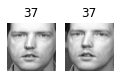

Cluster: 95


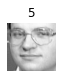

Cluster: 96


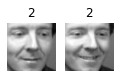

Cluster: 97


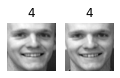

Cluster: 98


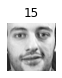

Cluster: 99


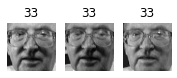

Cluster: 100


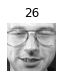

Cluster: 101


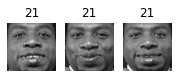

Cluster: 102


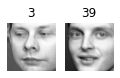

Cluster: 103


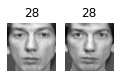

Cluster: 104


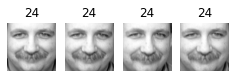

Cluster: 105


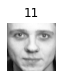

Cluster: 106


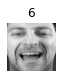

Cluster: 107


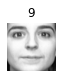

Cluster: 108


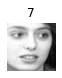

Cluster: 109


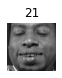

In [37]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1 
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in (np.unique(best_model.labels_)):
    print("Cluster:", cluster_id)
    in_cluster = best_model.labels_ == cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

About 2 out of 3 clsuters are useful; that is, they contain at least 2 pictures, all of the same person. However, the rest of the clusters have either one or more intruders, or they have just a single picture.

Clustering images this way might be imprecise to be directly useful when training a model, but it can help alot when labeling images in a new dataset - it will usuaaly make labelling much faster

### 11

Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set. Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set. Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach? What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?

- Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set

In [39]:
rnd_clf = RandomForestClassifier(n_estimators=150, random_state=42)
rnd_clf.fit(X_train_pca, y_train)
rnd_clf.score(X_valid_pca, y_valid)

0.9

- Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set

In [42]:
#best_model is our best model for KMeans algorithm
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca) 
X_test_reduced = best_model.transform(X_test_pca)

rnd_reduced_clf = RandomForestClassifier(n_estimators=150, random_state=42)
rnd_reduced_clf.fit(X_train_reduced, y_train)

rnd_reduced_clf.score(X_valid_reduced,y_valid)

0.7375

This isn't good news. Perhaps tuning the number of clusters might help

- Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach? 

Using GridSearchCV is possible, but we already have a validation set so we don't need K-fold cross-validation. Moreso, we're only exploring 1 hyperparameter, thus it's simpler to run a for loop manually

In [44]:
for n_cluster in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_cluster, random_state=42)),
        ("rnd_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_reduced, y_train)
    print(n_cluster, pipeline.score(X_valid_reduced, y_valid))

5 0.4125
10 0.475
15 0.4625
20 0.475
25 0.525
30 0.4875
35 0.5125
40 0.5
45 0.5375
50 0.525
55 0.5375
60 0.5375
65 0.5375
70 0.575
75 0.575
80 0.5625
85 0.5625
90 0.5875
95 0.55
100 0.55
105 0.5875
110 0.55
115 0.575
120 0.5625
125 0.5875
130 0.575
135 0.55
140 0.5875
145 0.575


It seems that even after tuning the number of clusters we didn't get beyond 60% accuracy. Looks like the distances to the cluster centroids aren't as informative as the original images

- What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?

In [45]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [46]:
rnd_extended_clf = RandomForestClassifier(n_estimators=150, random_state=42)
rnd_extended_clf.fit(X_train_extended, y_train)
rnd_extended_clf.score(X_valid_extended, y_valid)

0.8

That's better than the model with the reduced set (73.75%) but not as good as the the original model (90%). The clusters aren't useful to directly train a classifier in this case (but they can still help when labelling new training instances)

### 12

Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the
algorithm, you should probably reduce the dataset’s dimensionality (e.g., use
PCA, preserving 99% of the variance). Use the model to generate some new faces
(using the sample() method), and visualize them (if you used PCA, you will need
to use its inverse_transform() method). Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the score_samples() method for normal images and for anomalies).

- Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset’s dimensionality (e.g., use PCA, preserving 99% of the variance)

In [47]:
gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

-  Use the model to generate some new faces (using the sample() method), and visualize them (if you used PCA, you will need to use its inverse_transform() method)

In [50]:
n_gen_faces = 20
gen_reduced_face, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_reduced_face)

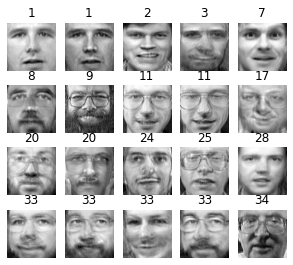

In [51]:
plot_faces(gen_faces, y_gen_faces)

- Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the score_samples() method for normal images and for anomalies

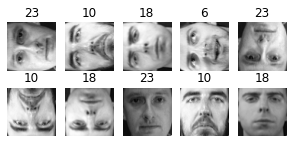

In [55]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad_faces = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad_faces)

In [56]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [57]:
gm.score_samples(X_bad_faces_pca)

array([-5.12919707e+07, -3.15310648e+07, -2.95897722e+07, -4.73996348e+07,
       -2.57863665e+07, -5.03268017e+07, -5.07725523e+07, -1.10080833e+08,
       -8.83095811e+07, -8.80760660e+07])

The bad faces are all cosidered highly unlikely by the Gaussian mixture model. Compare this to the scores of some training instances

In [59]:
gm.score_samples(X_train_pca[:10])

array([1168.94476777, 1118.66466032, 1118.66465836, 1129.35918259,
       1087.53034074, 1146.18455775, 1146.03684169, 1082.49224334,
       1168.65018044, 1129.3591813 ])

### 13

Some dimensionality reduction techniques can also be used for anomaly detection. For example, take the Olivetti faces dataset and reduce it with PCA, preserving 99% of the variance. Then compute the reconstruction error for each image. Next, take some of the modified images you built in the previous exercise, and look at their reconstruction error: notice how much larger the reconstruction error is. If you plot a reconstructed image, you will see why: it tries to reconstruct a normal face.

We've already reduced the dataset using PCA in question 10

In [61]:
X_train_pca

array([[ 2.2095602 ,  8.177865  , -3.1609123 , ...,  0.10565575,
         0.11277719, -0.12379589],
       [-2.8795319 , -5.852721  , -3.1102686 , ..., -0.19481394,
        -0.07905008,  0.09704518],
       [-3.7210045 , -3.7166855 , -1.6136078 , ...,  0.1077444 ,
         0.0685638 ,  0.02084196],
       ...,
       [ 0.02803438, -1.4935062 ,  2.3138235 , ...,  0.1283842 ,
        -0.06185969,  0.01100612],
       [-2.0366485 , -2.057368  ,  1.7076212 , ..., -0.11621464,
        -0.04620298,  0.02862727],
       [ 4.3340673 ,  0.7842253 , -1.6855742 , ...,  0.14180604,
        -0.18895902, -0.02666708]], dtype=float32)

In [62]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [65]:
reconstruction_errors(pca, X_train).mean()

0.00018892145

In [66]:
reconstruction_errors(pca, X_bad_faces).mean()

0.006214901

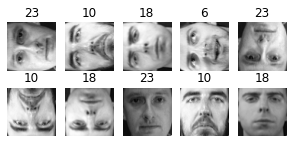

In [68]:
plot_faces(X_bad_faces, y_bad_faces)

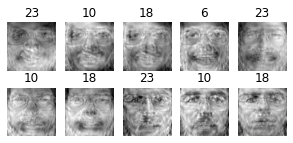

In [70]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad_faces)